# Import des outils / jeu de données

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTEN, SMOTENC
from keras import layers
from lightgbm import LGBMClassifier
from scipy.stats import boxcox
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from xgboost import XGBClassifier

In [ ]:
SEED = 0

In [ ]:
np.random.seed(SEED)
sns.set_theme()

In [ ]:
ID_COL = "PassengerId"
TARGET = "Survived"

In [ ]:
df = pd.read_csv(
    "data/train.csv",
    index_col=ID_COL,
)

## Variables globales

In [ ]:
LABELS = df[TARGET].unique()

In [ ]:
var_quanti = [
    "Age",
    "Fare",
]

In [ ]:
var_quali = [
    "Pclass",
    "Sex",
    "SibSp",
    "Parch",
    "Embarked",
]

In [ ]:
X = df.copy()[var_quanti + var_quali]
y = df[TARGET].copy()

In [ ]:
# le = LabelEncoder()
# y = le.fit_transform(y)

## Fonctions et variables utiles

In [ ]:
score_modeles = []

**Tableau.** Informations sur notre classification

|:---------------------------|:----------------------------------|
| **Objectif métier**        | Prédire l'acceptation à une campagne marketing |
| **Problème technique**     | Classification binaire supervisée |
| **Métrique**               | Score F1 sur la classe 1 (clients qui acceptent)<br>À score F1 égal, on choisit la meilleure précision sur la classe 1 |
| **Méthode d'entraînement** | Validation croisée en 5 blocs     |
| **Pré-traitement**         | Variables quantitatives : centrer/réduire<br>Variables qualitatives : OneHot Encoding (Tableau Disjonctif Complet) |
| **Équilibrage des classes**| 1) Aucun<br>2) Sous-échantillonnage aléatoire manuel<br>3) Sur-échantillonnage avec SMOTE |


In [ ]:
def evaluate_models(models, prefix, X_train, X_test, y_train, y_test):
    """Evalue tous les modèles dans `models` et sauvegarde les résultats avec un préfixe `prefix`
    (utile pour distinguer les différentes stratégies de pré-traitement des données)."""
    results = []

    for model_name, model in models.items():
        name = f"{prefix}/{model_name}"
        print(name)

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=5,
            scoring="accuracy",
        )

        scores_mean = scores.mean()
        scores_std = scores.std()

        results.append(
            [
                name,
                scores_mean,
                scores_std,
            ]
        )
        score_modeles.extend(
            (
                [
                    name,
                    "score_f1_classe1",
                    scores_mean,
                    scores_std,
                ],
            )
        )

    print(sorted(results, key=lambda x: x[1], reverse=True))

    return results

# Liste des modèles

**Tableau.** Liste des modèles de notre étude

|||
|:---------------------------|:----------------------------------|
| **Modèles de référence**   | Classificateur Idiot Uniforme (50% de oui et 50% de non)<br>Classificateur Idiot Constant 1 (100% de oui) |
| **Modèles linéaires**  | Régression logistique<br>Analyse Discriminante Linéaire |
| **Arbres de décision**               | Arbre de décision<br>Forêt d'arbres de décision (Random Forest) |
| **Gradient Boosting** | XGBoost<br>LightGBM<br>CatBoost |
| **Machine à vecteurs de support (SVM)** | Classificateur SVM linéaire |
| **k plus proches voisins (k-NN)** | Classificateur k-nn (5 voisins)<br>Classificateur k-nn (15 voisins) |
| **Modèle de vote**| Modèle de "Vote à la majorité" sur 5 modèles :<br>- Régression logistique<br>- Analyse discriminante linéaire<br>- Random Forest<br>- XGBoost<br>- CatBoost |
| **Réseau de neurones**| Réseau de neurones à 5 couches et 1 600 neurones |


In [ ]:
models = {
    "DummyClassifier_Uniform": DummyClassifier(strategy="uniform", random_state=SEED),
    "DummyClassifier_MostFrequent": DummyClassifier(
        strategy="most_frequent", random_state=SEED
    ),
    "KNeighborsClassifier5": KNeighborsClassifier(),
    "LinearSVC": LinearSVC(random_state=SEED),
    "LogisticRegression": LogisticRegression(random_state=SEED),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
    "RandomForestClassifier": RandomForestClassifier(random_state=SEED),
    "XGBClassifier": XGBClassifier(random_state=SEED),
    "CatBoostClassifier": CatBoostClassifier(random_state=SEED, verbose=False),
    "LGBMClassifier": LGBMClassifier(random_state=SEED),
}

# Todo

- refactor code
- refactor: include MCA in pipeline
- feature selection
- feature selection: train only on MCA columns? only MCA cols + some selected original variables?
- feature engineering: add clusters to variables
- SMOTE categorical
- code Tetsu https://www.kaggle.com/code/tetsutani/ps3e13-eda-decomposition-ensemble-rankpredict/notebook
- rajouter le temps pris par chaque algo dans la fonction qui évalue les modèles



# Traitement des données

## Pipeline Scaler & OneHotEncoding

In [ ]:
var_cat_non_ohe = []

In [ ]:
var_cat_ohe = var_quali

In [ ]:
quanti_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)

In [ ]:
quali_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
    ]
)

In [ ]:
preprocessor = ColumnTransformer(
    remainder="passthrough",
    transformers=[
        #         (
        #             "ohe",
        #             OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False),
        #             var_cat_ohe,
        #         ),
        ("quali_processor", quali_processor, var_quali),
        ("quanti_processor", quanti_processor, var_quanti),
    ],
)

In [ ]:
nouveau_df = pd.DataFrame(
    preprocessor.fit_transform(X),
    index=df.index,
    columns=preprocessor.get_feature_names_out(),
)

In [ ]:
nouveau_df.shape

(891, 7)

## Par défaut

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    nouveau_df, y, test_size=0.2, random_state=SEED
)

In [ ]:
y_train.head()

PassengerId
141    0
440    0
818    0
379    0
492    0
Name: Survived, dtype: int64

In [ ]:
prefix = "défaut"
results = evaluate_models(models, prefix, X_train, X_test, y_train, y_test)

défaut/DummyClassifier_Uniform
défaut/DummyClassifier_MostFrequent
défaut/KNeighborsClassifier5
défaut/LinearSVC


/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/kaggle-competitions-ww632Mhq-py3.1

défaut/LogisticRegression
défaut/LinearDiscriminantAnalysis
défaut/RandomForestClassifier
défaut/XGBClassifier
défaut/CatBoostClassifier
défaut/LGBMClassifier
[['défaut/CatBoostClassifier', 0.8229882793263075, 0.01889518371218075], ['défaut/LGBMClassifier', 0.8103614695163991, 0.019609010246083153], ['défaut/LinearSVC', 0.7963656062247612, 0.036797617433123125], ['défaut/LinearDiscriminantAnalysis', 0.7963459076135132, 0.03469373133000308], ['défaut/RandomForestClassifier', 0.7935487048163103, 0.02241115079215675], ['défaut/LogisticRegression', 0.792159952723333, 0.029508897707739568], ['défaut/XGBClassifier', 0.7921205555008373, 0.021657666780955345], ['défaut/KNeighborsClassifier5', 0.7822712498768837, 0.0404883546788373], ['défaut/DummyClassifier_MostFrequent', 0.6165763813651137, 0.002749420918840616], ['défaut/DummyClassifier_Uniform', 0.47193932827735646, 0.039742667051208304]]


In [ ]:
sorted(results, key=lambda x: x[1], reverse=True)

[['défaut/CatBoostClassifier', 0.8229882793263075, 0.01889518371218075],
 ['défaut/LGBMClassifier', 0.8103614695163991, 0.019609010246083153],
 ['défaut/LinearSVC', 0.7963656062247612, 0.036797617433123125],
 ['défaut/LinearDiscriminantAnalysis',
  0.7963459076135132,
  0.03469373133000308],
 ['défaut/RandomForestClassifier', 0.7935487048163103, 0.02241115079215675],
 ['défaut/LogisticRegression', 0.792159952723333, 0.029508897707739568],
 ['défaut/XGBClassifier', 0.7921205555008373, 0.021657666780955345],
 ['défaut/KNeighborsClassifier5', 0.7822712498768837, 0.0404883546788373],
 ['défaut/DummyClassifier_MostFrequent',
  0.6165763813651137,
  0.002749420918840616],
 ['défaut/DummyClassifier_Uniform', 0.47193932827735646, 0.039742667051208304]]

# Diagnostic du modèle

## RandomForest feature importance

In [ ]:
nom_colonnes = preprocessor.get_feature_names_out(X.columns)

In [ ]:
nom_colonnes = list(map(lambda x: x.split("__")[1], nom_colonnes))

In [ ]:
nom_colonnes = nom_colonnes + list(df.columns[len(nom_colonnes) :])

In [ ]:
model_to_diagnose = models[6][0]

In [ ]:
model_to_diagnose.fit(X_train, y_train)

<catboost.core.CatBoostClassifier>

In [ ]:
fi = model_to_diagnose.feature_importances_

In [ ]:
len(fi)

25

In [ ]:
fi = pd.DataFrame(fi.reshape((1, len(fi))), columns=nom_colonnes)

In [ ]:
fi = fi.sort_values(
    by=0, axis=1, ascending=False
)  # trier les colonnes en fonction de la ligne 0

<Axes: title={'center': "Importance donnée par le modèle <class 'catboost.core.CatBoostClassifier'>"}>

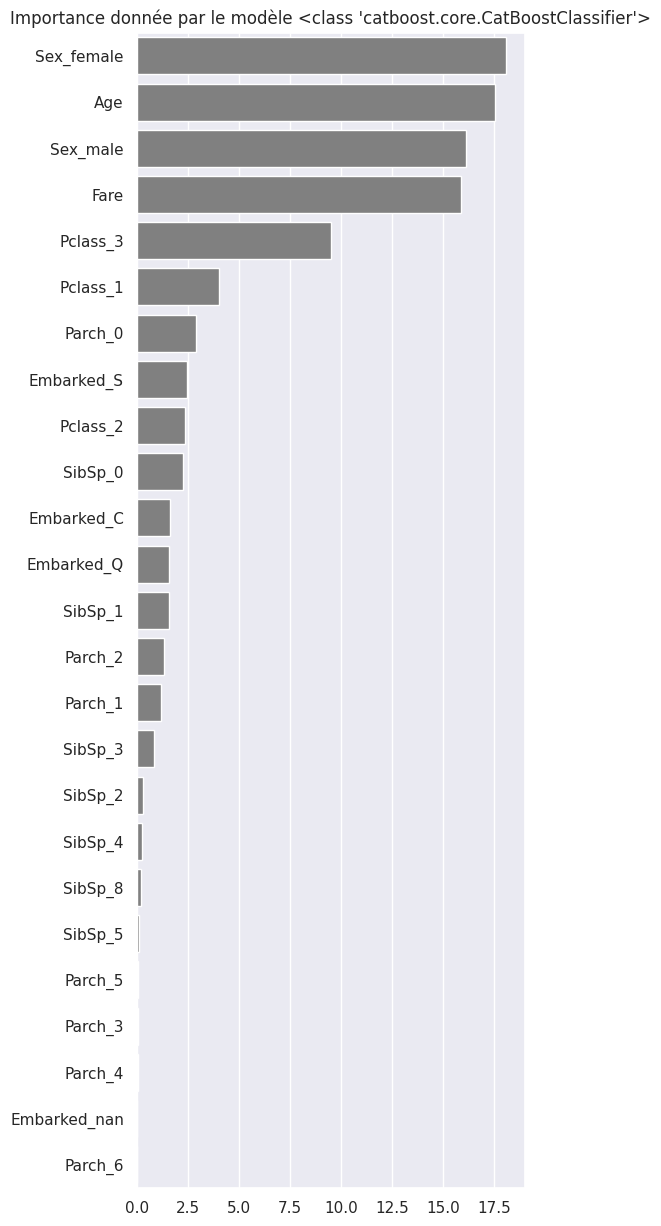

In [ ]:
plt.figure(figsize=(5, 15))
plt.title(f"Importance donnée par le modèle {model_to_diagnose.__class__}")
sns.barplot(fi, orient="h", color="gray")

## Permutation importance

In [ ]:
result = permutation_importance(
    model_to_diagnose, X_test, y_test, n_repeats=10, random_state=SEED
)

In [ ]:
# sns.histplot(result.importances_std < 0.015)

In [ ]:
pi_results = result.importances_mean

In [ ]:
pi_results = pd.DataFrame(
    pi_results.reshape((1, len(pi_results))), columns=nom_colonnes
)
pi_results = pi_results.sort_values(by=0, axis=1, ascending=False)

In [ ]:
(pi_results.T > 0).index

Index(['ohe__Sex_male', 'scaler__Age', 'ohe__Pclass_3', 'scaler__Fare',
       'ohe__SibSp_1', 'ohe__Sex_female', 'ohe__Parch_1', 'ohe__SibSp_0',
       'ohe__Pclass_2', 'ohe__Parch_0', 'ohe__Pclass_1', 'ohe__SibSp_8',
       'ohe__SibSp_4', 'ohe__Parch_3', 'ohe__Parch_4', 'ohe__Parch_5',
       'ohe__Parch_6', 'ohe__Embarked_C', 'ohe__Embarked_Q', 'ohe__Embarked_S',
       'ohe__Embarked_nan', 'ohe__SibSp_5', 'ohe__SibSp_2', 'ohe__SibSp_3',
       'ohe__Parch_2'],
      dtype='object')

<Axes: title={'center': "Importance de Permutation du modèle <class 'catboost.core.CatBoostClassifier'>"}>

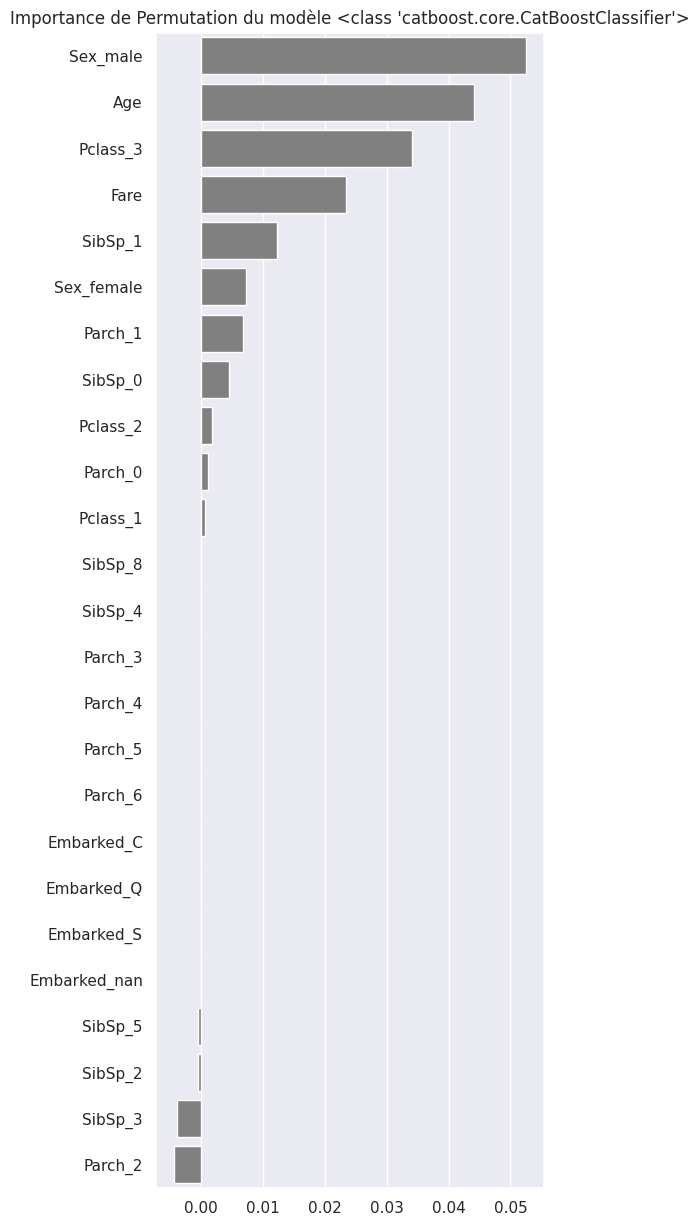

In [ ]:
plt.figure(figsize=(5, 15))
plt.title(f"Importance de Permutation du modèle {model_to_diagnose.__class__}")
sns.barplot(pi_results, orient="h", color="gray")

# Feature selection

## Permutation Importance

In [ ]:
pi_variables1 = [
    "ohe__SibSp_8",
    "ohe__SibSp_4",
    "ohe__Parch_3",
    "ohe__Parch_4",
    "ohe__Parch_5",
    "ohe__Parch_6",
    "ohe__Embarked_C",
    "ohe__Embarked_Q",
    "ohe__Embarked_S",
    "ohe__Embarked_nan",
    "ohe__SibSp_5",
    "ohe__SibSp_2",
    "ohe__SibSp_3",
    "ohe__Parch_2",
]

In [ ]:
pi_variables = pi_variables1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    nouveau_df, y, test_size=0.2, random_state=SEED
)

In [ ]:
X_train.drop(pi_variables, axis=1, inplace=True)

In [ ]:
prefix = "pi"
results = evaluate_models(models, prefix, X_train, X_test, y_train, y_test)

pi/DummyClassifier_Uniform
pi/DummyClassifier_MostFrequent
pi/LogisticRegression
pi/LinearDiscriminantAnalysis
pi/RandomForestClassifier
pi/XGBClassifier
pi/CatBoostClassifier
pi/LGBMClassifier
[['pi/CatBoostClassifier', 0.8089924160346695, 0.019930736152543416], ['pi/LGBMClassifier', 0.806175514626219, 0.020647100107749422], ['pi/LinearDiscriminantAnalysis', 0.803398010440264, 0.029983645012275125], ['pi/XGBClassifier', 0.8019797104304146, 0.014829764262890108], ['pi/LogisticRegression', 0.8005712597261894, 0.03399472676161792], ['pi/RandomForestClassifier', 0.7864966019895597, 0.02778247324920939], ['pi/DummyClassifier_MostFrequent', 0.6165763813651137, 0.002749420918840616], ['pi/DummyClassifier_Uniform', 0.47193932827735646, 0.039742667051208304]]


In [ ]:
sorted(results, key=lambda x: x[1], reverse=True)

[['pi/CatBoostClassifier', 0.8089924160346695, 0.019930736152543416],
 ['pi/LGBMClassifier', 0.806175514626219, 0.020647100107749422],
 ['pi/LinearDiscriminantAnalysis', 0.803398010440264, 0.029983645012275125],
 ['pi/XGBClassifier', 0.8019797104304146, 0.014829764262890108],
 ['pi/LogisticRegression', 0.8005712597261894, 0.03399472676161792],
 ['pi/RandomForestClassifier', 0.7864966019895597, 0.02778247324920939],
 ['pi/DummyClassifier_MostFrequent', 0.6165763813651137, 0.002749420918840616],
 ['pi/DummyClassifier_Uniform', 0.47193932827735646, 0.039742667051208304]]

# Pour aller plus loin

- afficher les intervalles de confiance des scores de validation croisée
- optimiser les hyper-paramètres des modèles (avec une recherche en grille ou une recherche bayésienne)
- tester les modèles sur différents sous-ensembles de variables pour les comparer

# Sauvegarde des données

In [ ]:
score_modeles_df = pd.DataFrame(
    score_modeles, columns=["Modèle", "Métrique", "Valeur", "Ecart type"]
)

In [ ]:
score_modeles_df.to_csv("data/results/classifications.csv", index=False)

# Soumission Kaggle

In [ ]:
X_kaggle = pd.read_csv("data/test.csv", index_col=ID_COL)

In [ ]:
X_kaggle.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
best_model = models["CatBoostClassifier"]
best_model

<catboost.core.CatBoostClassifier>

In [ ]:
X_preprocessed = preprocessor.transform(X)

In [ ]:
pd.DataFrame(X_preprocessed, columns=preprocessor.get_feature_names_out())

,quali_processor__Pclass,quali_processor__Sex,quali_processor__SibSp,quali_processor__Parch,quali_processor__Embarked,quanti_processor__Age,quanti_processor__Fare
0,2.0,1.0,1.0,0.0,2.0,-0.592481,-0.502445
1,0.0,0.0,1.0,0.0,0.0,0.638789,0.786845
2,2.0,0.0,0.0,0.0,2.0,-0.284663,-0.488854
3,0.0,0.0,1.0,0.0,2.0,0.407926,0.420730
4,2.0,1.0,0.0,0.0,2.0,0.407926,-0.486337
...,...,...,...,...,...,...,...
886,1.0,1.0,0.0,0.0,2.0,-0.207709,-0.386671
887,0.0,0.0,0.0,0.0,2.0,-0.823344,-0.044381
888,2.0,0.0,1.0,2.0,2.0,0.000000,-0.176263
889,0.0,1.0,0.0,0.0,0.0,-0.284663,-0.044381


In [ ]:
best_model.fit(X_train, y_train)

<catboost.core.CatBoostClassifier>

In [ ]:
X_kaggle_processed = pd.DataFrame(
    preprocessor.transform(X_kaggle),
    columns=preprocessor.get_feature_names_out(),
)

In [ ]:
# X_kaggle_processed.drop(pi_variables, axis=1, inplace=True)

In [ ]:
y_pred = best_model.predict(X_kaggle_processed)

In [ ]:
liste_predictions = pd.DataFrame(y_pred, index=X_kaggle.index, columns=[TARGET])

In [ ]:
submission_name = "ordinal_encoder"

In [ ]:
liste_predictions.to_csv(f"data/results/{submission_name}.csv")